In [66]:
import pandas as pd
import numpy as np

import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
import sklearn
from sklearn.preprocessing import normalize, StandardScaler

import calendar
import datetime, time

import gc
import os

import matplotlib
% matplotlib inline

In [67]:
out_dir = "/home/data/kaggle-zillow/submissions/"

if not os.path.exists(out_dir):
    os.makedirs(out_dir)

# Load formatted data

In [32]:
# training data

train_df = pd.read_csv("/home/data/kaggle-zillow/processed/train_formatted.csv")
train_df.drop("Unnamed: 0", axis=1, inplace=True)

train_df_dum = pd.get_dummies(train_df, columns=categ_cols, drop_first=False)


feature_names = train_df.drop(["logerror", "parcelid"], axis=1).columns.values.tolist()

In [33]:
# pre-processing on the train data
X_train = train_df.drop(["logerror", "parcelid"], axis=1).values
y_train = train_df['logerror'].values

# idx = (y_train > -0.4) & (y_train < 0.418)
# X_train = X_train[idx,:]
# y_train = y_train[idx]

# X_train = normalize(X_train, norm='l2', axis=0, copy=True, return_norm=False)
scaler = StandardScaler().fit(X_train)
X_train= scaler.transform(X_train)

In [42]:
# test data

test_df = pd.read_csv("/home/data/kaggle-zillow/processed/sample_formatted.csv")
month_cols = ['transactionmonth_Apr',
 'transactionmonth_Aug',
 'transactionmonth_Dec',
 'transactionmonth_Feb',
 'transactionmonth_Jan',
 'transactionmonth_Jul',
 'transactionmonth_Jun',
 'transactionmonth_Mar',
 'transactionmonth_May',
 'transactionmonth_Nov',
 'transactionmonth_Oct',
 'transactionmonth_Sep']

for c in month_cols:
    test_df[c] = 0
    
X_test = test_df[[c for c in feature_names if c in test_df.columns]].values

smpl_cols = ["201610", "201611", "201612", "201710", "201711", "201712"]
smpl_cols = dict(zip(smpl_cols, ["transactionmonth_" + \
                calendar.month_abbr[int(x[-2:])] for x in smpl_cols]))

In [44]:
test_df.shape, X_test.shape

((2985217, 113), (2985217, 101))

In [47]:
set(test_df.columns) - set(feature_names)

{'Unnamed: 0',
 'airconditioningtypeid_12',
 'architecturalstyletypeid_27',
 'architecturalstyletypeid_5',
 'fips_0',
 'heatingorsystemtypeid_19',
 'heatingorsystemtypeid_21',
 'parcelid',
 'propertylandusetypeid_0',
 'propertylandusetypeid_270',
 'typeconstructiontypeid_10',
 'typeconstructiontypeid_11'}

# LGB model

### Train model

In [36]:
d_train = lgb.Dataset(X_train, label=y_train)

params = {}
params['max_bin'] = 10
params['learning_rate'] = 0.0021 # shrinkage_rate
params['boosting_type'] = 'gbdt'
params['objective'] = 'regression'
params['metric'] = 'l1'          # or 'mae'
params['sub_feature'] = 0.5      # feature_fraction -- OK, back to .5, but maybe later increase this
params['bagging_fraction'] = 0.85 # sub_row
params['bagging_freq'] = 40
params['num_leaves'] = 512        # num_leaf
params['min_data'] = 500         # min_data_in_leaf
params['min_hessian'] = 0.05     # min_sum_hessian_in_leaf
params['verbose'] = 2

print("\nFitting LightGBM model ...")
clf = lgb.train(params, d_train, 430)



Fitting LightGBM model ...


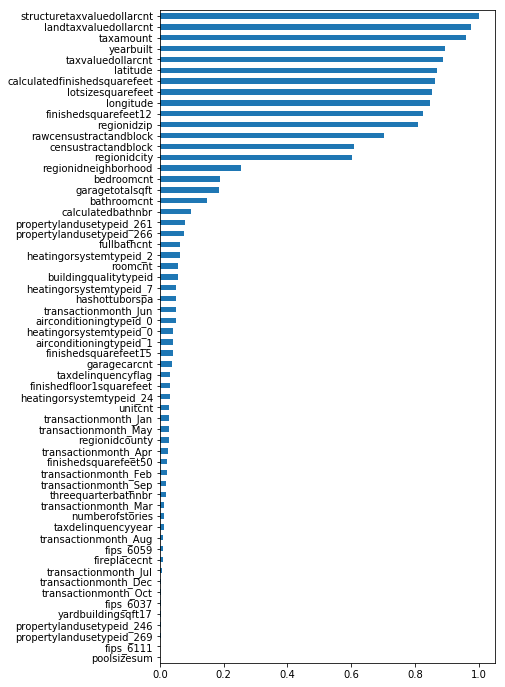

In [37]:
feature_importance = clf.feature_importance()
feature_importance = feature_importance / float(feature_importance.max())

feature_importance = pd.Series(dict(zip(feature_names, feature_importance)))
feature_importance.sort_values(inplace=True)
feature_importance[feature_importance>0].plot(kind="barh", figsize=(6,12))

In [86]:
params

{'bagging_fraction': 0.85,
 'bagging_freq': 40,
 'boosting_type': 'gbdt',
 'learning_rate': 0.0021,
 'max_bin': 255,
 'metric': 'l1',
 'min_data': 500,
 'min_hessian': 0.05,
 'num_leaves': 512,
 'objective': 'regression',
 'sub_feature': 0.5,
 'verbose': 2}

### Cross-validation to compute out-of-sample accuracy

In [76]:
N_FOLDS = 5

cv_results = lgb.cv(params, d_train, num_boost_round=500, nfold=N_FOLDS, 
                    verbose_eval=100, early_stopping_rounds=40)
print('Current parameters:\n', params)
print('\nBest num_boost_round:', len(cv_results['l1-mean']))
print('Best CV score:', cv_results['l1-mean'][-1])

[100]	cv_agg's l1: 0.0682448 + 0.000629516
[200]	cv_agg's l1: 0.0681095 + 0.000629917
[300]	cv_agg's l1: 0.0680249 + 0.000626366
[400]	cv_agg's l1: 0.0679738 + 0.000625898
[500]	cv_agg's l1: 0.0679423 + 0.000621672
('Current parameters:\n', {'num_leaves': 512, 'sub_feature': 0.5, 'min_hessian': 0.05, 'verbose': 2, 'bagging_freq': 40, 'learning_rate': 0.0021, 'min_data': 500, 'max_bin': 255, 'objective': 'regression', 'bagging_fraction': 0.85, 'metric': 'l1', 'boosting_type': 'gbdt'})
('\nBest num_boost_round:', 500)
('Best CV score:', 0.067942328800631807)


In [79]:
cv_results.keys()

[u'l1-mean', u'l1-stdv']

In [77]:
cv_score = cv_results['l1-mean'][-1]

### Predict on test data and format for submission

In [58]:
print("\nStart LightGBM prediction ...")
# num_threads > 1 will predict very slow in kernal
clf.reset_parameter({"num_threads":8})

# the only difference in the submission columns is the value of the month for which the prediction is being made
# so let's set the value of the respective dummy column to 1

submission = {}
x = X_test.copy()
for cp,cs in smpl_cols.iteritems():
    i = feature_names.index(cs)
    print "Making predictions for %s (index %d, column name %s)" % (cp, i, cs)
    x[:,i] = 1
    submission[cp] = clf.predict(x)
    x[:,i] = 0

submission = pd.DataFrame(submission)
submission['ParcelId'] = test_df['parcelid']
submission.set_index('ParcelId', inplace=True)


Start LightGBM prediction ...
Making predictions for 201612 (index 91, column name transactionmonth_Dec)
Making predictions for 201610 (index 99, column name transactionmonth_Oct)
Making predictions for 201611 (index 98, column name transactionmonth_Nov)
Making predictions for 201712 (index 91, column name transactionmonth_Dec)
Making predictions for 201711 (index 98, column name transactionmonth_Nov)
Making predictions for 201710 (index 99, column name transactionmonth_Oct)


In [82]:
cur_date = datetime.datetime.now()
filename = cur_date.strftime("%y-%m-%d_%H:%M:%S") + "_%2.5f.csv"%cv_score

submission.to_csv(out_dir + "/" + filename)

# Predict using XGBoost

In [ ]:

##### RUN XGBOOST

print("\nSetting up data for XGBoost ...")
# xgboost params
xgb_params = {
    'eta': 0.037,
    'max_depth': 5,
    'subsample': 0.80,
    'objective': 'reg:linear',
    'eval_metric': 'mae',
    'lambda': 0.8,   
    'alpha': 0.4, 
    'base_score': y_mean,
    'silent': 1
}
# Enough with the ridiculously overfit parameters.
# I'm going back to my version 20 instead of copying Jayaraman.
# I want a num_boost_rounds that's chosen by my CV,
# not one that's chosen by overfitting the public leaderboard.
# (There may be underlying differences between the train and test data
#  that will affect some parameters, but they shouldn't affect that.)

dtrain = xgb.DMatrix(x_train, y_train)
dtest = xgb.DMatrix(x_test)

# cross-validation
#print( "Running XGBoost CV ..." )
#cv_result = xgb.cv(xgb_params, 
#                   dtrain, 
#                   nfold=5,
#                   num_boost_round=350,
#                   early_stopping_rounds=50,
#                   verbose_eval=10, 
#                   show_stdv=False
#                  )
#num_boost_rounds = len(cv_result)

# num_boost_rounds = 150
num_boost_rounds = 242
print("\nXGBoost tuned with CV in:")
print("   https://www.kaggle.com/aharless/xgboost-without-outliers-tweak ")
print("num_boost_rounds="+str(num_boost_rounds))

# train model
print( "\nTraining XGBoost ...")
model = xgb.train(dict(xgb_params, silent=1), dtrain, num_boost_round=num_boost_rounds)

print( "\nPredicting with XGBoost ...")
xgb_pred = model.predict(dtest)

print( "\nXGBoost predictions:" )
print( pd.DataFrame(xgb_pred).head() )



##### COMBINE PREDICTIONS

print( "\nCombining XGBoost and LightGBM predicitons ..." )
xgb_weight = 1 - lgb_weight
pred = xgb_weight*xgb_pred + lgb_weight*p_test

print( "\nCombined predictions:" )
print( pd.DataFrame(pred).head() )



##### WRITE THE RESULTS

print( "\nPreparing results for write ..." )
y_pred=[]

for i,predict in enumerate(pred):
    y_pred.append(str(round(predict,4)))
y_pred=np.array(y_pred)

output = pd.DataFrame({'ParcelId': properties['parcelid'].astype(np.int32),
        '201610': y_pred, '201611': y_pred, '201612': y_pred,
        '201710': y_pred, '201711': y_pred, '201712': y_pred})
# set col 'ParceID' to first col
cols = output.columns.tolist()
cols = cols[-1:] + cols[:-1]
output = output[cols]
from datetime import datetime

print( "\nWriting results to disk ..." )
output.to_csv('sub{}.csv'.format(datetime.now().strftime('%Y%m%d_%H%M%S')), index=False)

print( "\nFinished ..." )